### Christina Lv
### Recession Probability Model 

In [1]:
import pandas as pd 
import numpy as np 
import quandl 
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt 

import plotly as plotly
import plotly.graph_objs as go
import plotly.express as px

import seaborn as sns

In [2]:
!conda install -c conda-forge fbprophet -y
#!pip install --upgrade plotly


Solving environment: done

# All requested packages already installed.



In [97]:
#!pip install fbprophet

In [3]:
import pandas as pd
from fbprophet import Prophet

In [4]:
import quandl
quandl.ApiConfig.api_key = 'AtPuHRXs-rLGozrAYSKk'

In [86]:
ten_year = quandl.get("FRED/DGS10", collapse="daily") #10-Year Treasury Constant Maturity Rate


three_month = quandl.get("FRED/DTB3", collapse="daily") #3-month treasury bill - secondary market rate 


In [87]:
data = pd.DataFrame()
data['3_month'] = three_month.Value
data['10YR'] = ten_year.Value

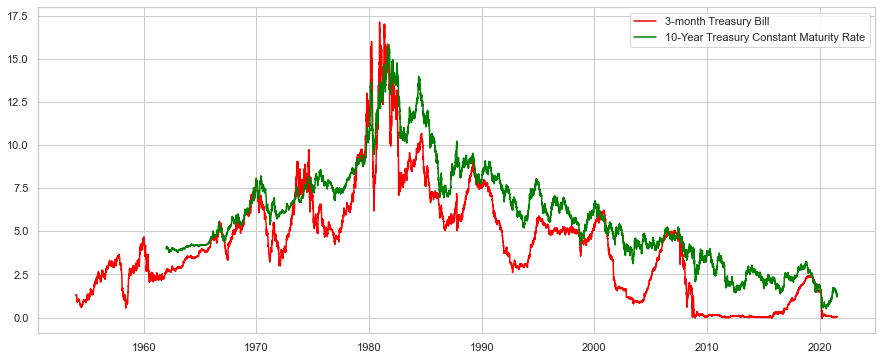

In [88]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))

plt.plot(data['3_month'], color='red', label='3-month Treasury Bill')
plt.plot(data['10YR'], color='green', label='10-Year Treasury Constant Maturity Rate')
plt.legend()

In [89]:
data["diff"] = (data['10YR'] - data['3_month'])


In [90]:
data['10YR']

Date
1954-01-04     NaN
1954-01-05     NaN
1954-01-06     NaN
1954-01-07     NaN
1954-01-08     NaN
              ... 
2021-07-20    1.23
2021-07-21    1.30
2021-07-22    1.27
2021-07-23    1.30
2021-07-26    1.29
Name: 10YR, Length: 16883, dtype: float64

In [91]:
data['3_month']

Date
1954-01-04    1.33
1954-01-05    1.28
1954-01-06    1.28
1954-01-07    1.31
1954-01-08    1.31
              ... 
2021-07-20    0.05
2021-07-21    0.05
2021-07-22    0.05
2021-07-23    0.05
2021-07-26    0.05
Name: 3_month, Length: 16883, dtype: float64

In [92]:
data = data[data['10YR'].notna()]

In [93]:
data

,3_month,10YR,diff
Date,,,
1962-01-02,2.70,4.06,1.36
1962-01-03,2.73,4.03,1.30
1962-01-04,2.72,3.99,1.27
1962-01-05,2.74,4.02,1.28
1962-01-08,2.78,4.03,1.25
...,...,...,...
2021-07-20,0.05,1.23,1.18
2021-07-21,0.05,1.30,1.25
2021-07-22,0.05,1.27,1.22


In [94]:
data['DIFF'] = data['10YR'].subtract(data['3_month'])

In [95]:
df = pd.DataFrame()
df['DIFF'] = data['DIFF'] 
df


,DIFF
Date,
1962-01-02,1.36
1962-01-03,1.30
1962-01-04,1.27
1962-01-05,1.28
1962-01-08,1.25
...,...
2021-07-20,1.18
2021-07-21,1.25
2021-07-22,1.22


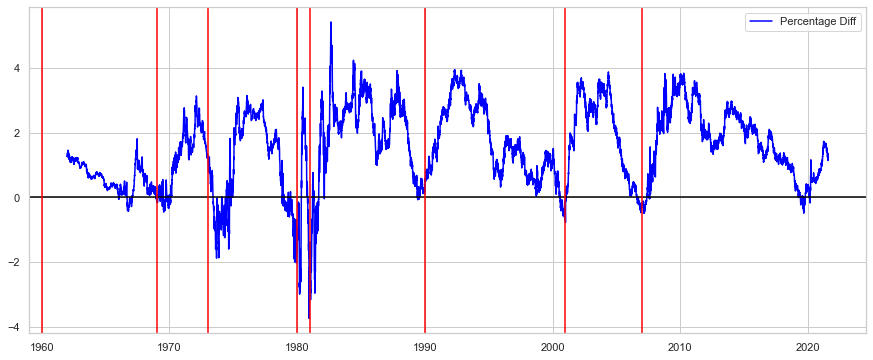

In [96]:
import datetime as dt

sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.plot(df['DIFF'], color='blue', label='Percentage Diff')
plt.legend()

plt.axhline(0, color='black')

years = [1960, 1969, 1973, 1980, 1981, 1990, 2001, 2007]

for year in years:
    plt.axvline(dt.datetime(year, 1, 1), color='red')

#### Approaches

In [145]:
df_prophet = pd.DataFrame(df.DIFF)
df_prophet.reset_index(inplace=True)
df_prophet.columns = ['ds', 'y']

In [146]:
model=Prophet(changepoint_prior_scale=1, changepoint_range=1)

In [147]:
df_prophet.columns

Index(['ds', 'y'], dtype='object')

In [148]:
model.fit(df_prophet) #disabled daily and weekly seasonality --> taking the yearly seasonality  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [149]:
model.component_modes


{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [150]:
df_prophet.tail() ### Tail of the actual data 

,ds,y
14872,2021-07-20,1.18
14873,2021-07-21,1.25
14874,2021-07-22,1.22
14875,2021-07-23,1.25
14876,2021-07-26,1.24


In [151]:
### Create future dates of 540 days (roughly 18 months)
future_dates=model.make_future_dataframe(periods=540, freq='D')

In [152]:
future_dates.tail() 

,ds
15472,2023-03-14
15473,2023-03-15
15474,2023-03-16
15475,2023-03-17
15476,2023-03-18


In [153]:
prediction=model.predict(future_dates)

In [155]:
prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
15472,2023-03-14,1.839011,0.560887,2.926398,0.906740,2.753945,-0.018465,-0.018465,-0.018465,0.000950,0.000950,0.000950,-0.019415,-0.019415,-0.019415,0.0,0.0,0.0,1.820546
15473,2023-03-15,1.840142,0.488414,3.109668,0.903987,2.757270,-0.005658,-0.005658,-0.005658,0.012091,0.012091,0.012091,-0.017748,-0.017748,-0.017748,0.0,0.0,0.0,1.834485
15474,2023-03-16,1.841273,0.444708,3.206232,0.901233,2.760596,0.007505,0.007505,0.007505,0.023484,0.023484,0.023484,-0.015979,-0.015979,-0.015979,0.0,0.0,0.0,1.848779
15475,2023-03-17,1.842405,0.551200,3.159378,0.898104,2.763921,0.004387,0.004387,0.004387,0.018522,0.018522,0.018522,-0.014135,-0.014135,-0.014135,0.0,0.0,0.0,1.846792
15476,2023-03-18,1.843536,0.476833,3.058919,0.895698,2.768794,-0.047905,-0.047905,-0.047905,-0.035662,-0.035662,-0.035662,-0.012243,-0.012243,-0.012243,0.0,0.0,0.0,1.795631


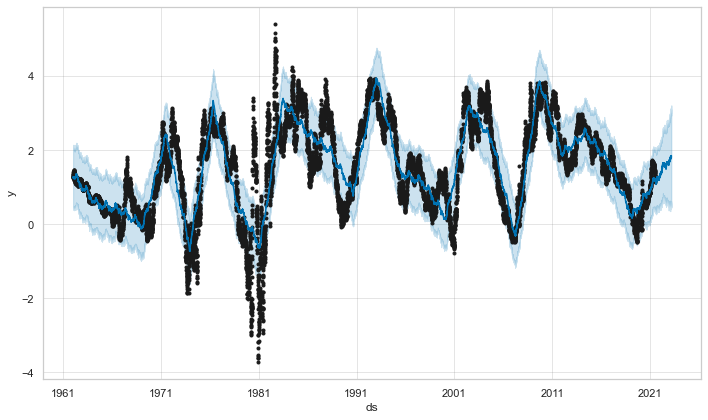

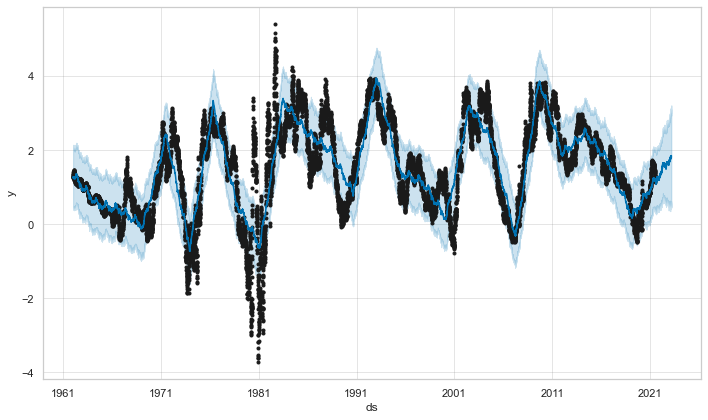

In [158]:
### plot the predicted projection
model.plot(prediction)

In [161]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
15472,2023-03-14,1.820546,0.560887,2.926398
15473,2023-03-15,1.834485,0.488414,3.109668
15474,2023-03-16,1.848779,0.444708,3.206232
15475,2023-03-17,1.846792,0.551200,3.159378
15476,2023-03-18,1.795631,0.476833,3.058919


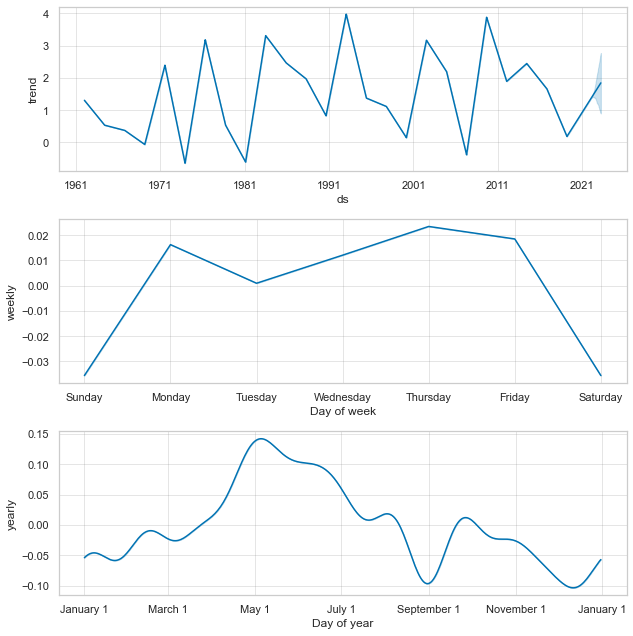

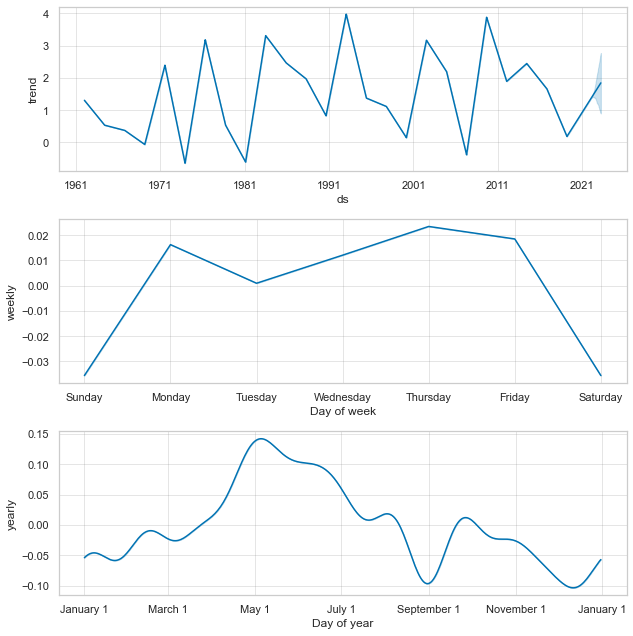

In [162]:
model.plot_components(prediction)

In [163]:
cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecasting = prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds')

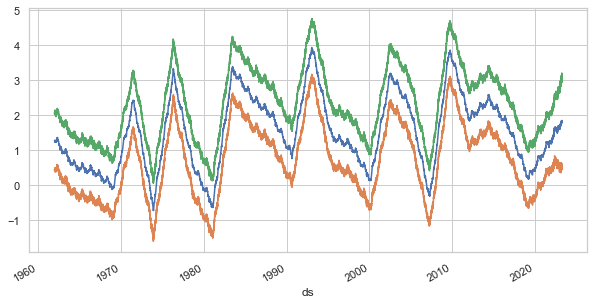

In [164]:
plt.figure(figsize=(10, 5))
plt.plot()

for i in range(1, 4):
#     plt.subplot(2, 1, i)
    forecasting[cols[i]].plot()

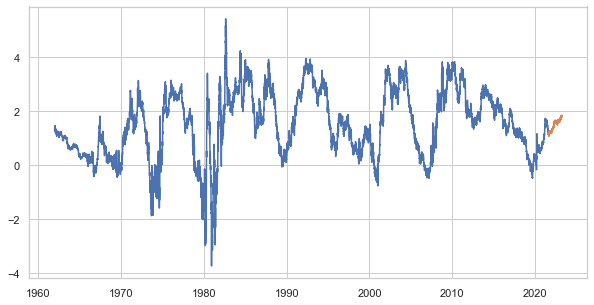

In [170]:
plt.figure(figsize=(10, 5))
plt.plot(df.DIFF)
plt.plot(forecasting['2021-07-10':]['yhat'])

### Prediction Results Manipulation

In [173]:
### Convert daily into monthly data 
forecasting.tail()

,yhat,yhat_lower,yhat_upper
ds,,,
2023-03-14,1.820546,0.560887,2.926398
2023-03-15,1.834485,0.488414,3.109668
2023-03-16,1.848779,0.444708,3.206232
2023-03-17,1.846792,0.551200,3.159378
2023-03-18,1.795631,0.476833,3.058919


In [176]:
forecasting_dates=forecasting.index.to_frame().reset_index(drop=True)

In [177]:
forecasting.index

DatetimeIndex(['1962-01-02', '1962-01-03', '1962-01-04', '1962-01-05',
               '1962-01-08', '1962-01-09', '1962-01-10', '1962-01-11',
               '1962-01-12', '1962-01-15',
               ...
               '2023-03-09', '2023-03-10', '2023-03-11', '2023-03-12',
               '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16',
               '2023-03-17', '2023-03-18'],
              dtype='datetime64[ns]', name='ds', length=15477, freq=None)

In [178]:
forecasting = forecasting.reset_index()

In [179]:
forecasting.head(20)

,ds,yhat,yhat_lower,yhat_upper
0,1962-01-02,1.253110,0.441343,2.076332
1,1962-01-03,1.265290,0.418781,2.055359
2,1962-01-04,1.277384,0.432925,2.023790
3,1962-01-05,1.272770,0.451855,2.055017
4,1962-01-08,1.269446,0.416495,2.117699
5,1962-01-09,1.253087,0.440278,2.047778
6,1962-01-10,1.262899,0.460278,2.048880
7,1962-01-11,1.272702,0.462053,2.084397
8,1962-01-12,1.265927,0.451713,2.144013
9,1962-01-15,1.257391,0.455629,2.061610


In [205]:
new_yhat = forecasting.resample('MS').mean()

print(new_yhat)

                yhat  yhat_lower  yhat_upper
ds                                          
1962-01-01  1.253424    0.434260    2.056417
1962-02-01  1.259415    0.441682    2.051553
1962-03-01  1.242570    0.442717    2.049317
1962-04-01  1.295414    0.509291    2.103659
1962-05-01  1.326755    0.529221    2.128698
...              ...         ...         ...
2022-11-01  1.651213    0.554800    2.727625
2022-12-01  1.649803    0.507152    2.764933
2023-01-01  1.721704    0.521207    2.888474
2023-02-01  1.788001    0.513986    3.002210
2023-03-01  1.812949    0.498459    3.057310

[735 rows x 3 columns]


In [207]:
### Create new catgorical variable - tag recession regime 

def func(x):
    if x <= 0:
        return 'Recessionary Period'
    elif x > 0:
        return 'Non-recessionary Period'
    return 'zzz'

new_yhat['recession'] = new_yhat['yhat'].apply(func)

In [212]:
new_yhat.tail(200)

,yhat,yhat_lower,yhat_upper,recession
ds,,,,
2006-08-01,0.330361,-0.461704,1.134295,Non-recessionary Period
2006-09-01,0.241769,-0.559282,1.046332,Non-recessionary Period
2006-10-01,0.164803,-0.637941,0.948645,Non-recessionary Period
2006-11-01,0.037957,-0.748987,0.847924,Non-recessionary Period
2006-12-01,-0.088882,-0.890669,0.720795,Recessionary Period
...,...,...,...,...
2022-11-01,1.651213,0.554800,2.727625,Non-recessionary Period
2022-12-01,1.649803,0.507152,2.764933,Non-recessionary Period
2023-01-01,1.721704,0.521207,2.888474,Non-recessionary Period


In [215]:
new_yhat.to_csv('recession_regime.csv')